In [1]:
### DRPreter Graph Embedding + PaDEL Descriptor + ResNet

import os
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from pandas import DataFrame
from datetime import datetime
import keras
from keras import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers import Conv1D, MaxPooling1D ,AveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras import backend as K

In [2]:
import pandas as pd
train_data = pd.read_csv('/data/yingfei/cancer_data/train_data.csv')
test_data = pd.read_csv('/data/yingfei/cancer_data/test_data.csv')

In [3]:
from sklearn.model_selection import train_test_split
with open('./Data/train_celllines_v1_1111.txt') as f:
    train_index = list(map(lambda x: x[:-1],f.readlines()))
train_set_index, val_set_index = train_test_split(train_index, test_size=0.1, random_state=42)

In [4]:
train_data = train_data.loc[train_data['auc'] >= 0]
train_data = train_data.reset_index(drop = True)
train_data

,ARXSPAN_ID,DRUG_NAME,ABL1,ACVR1B,AKT1,AKT2,AKT3,ALK,ALOX12B,FAM123B,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,auc
0,ACH-000001,JW-7-24-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.778432
1,ACH-000001,KIN001-260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.951321
2,ACH-000001,NSC-87877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.840287
3,ACH-000001,PLX-4720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.936410
4,ACH-000001,ERK5-IN-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.891908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203913,ACH-001716,KIN001-236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.956865
203914,ACH-001716,LUMINESPIB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.975168
203915,ACH-001716,NUTLIN-3A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.871995
203916,ACH-001716,SGC0946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.975417


In [5]:
train_data_new = train_data.loc[train_data.ARXSPAN_ID.isin(train_set_index)].copy()
train_data_new = train_data_new.reset_index(drop = True)
val_data_new = train_data.loc[train_data.ARXSPAN_ID.isin(val_set_index)].copy() 
val_data_new = val_data_new.reset_index(drop = True)

In [6]:
test_data_new = test_data.loc[test_data['auc'] >= 0]
test_data_new = test_data_new.reset_index(drop = True)
test_data_new

,ARXSPAN_ID,DRUG_NAME,ABL1,ACVR1B,AKT1,AKT2,AKT3,ALK,ALOX12B,FAM123B,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,auc
0,ACH-000802,JW-7-24-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.528562
1,ACH-000802,KIN001-260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.930958
2,ACH-000802,NSC-87877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.759249
3,ACH-000802,PLX-4720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.936510
4,ACH-000802,ERK5-IN-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.823453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22873,ACH-000438,KIN001-266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.975578
22874,ACH-000438,LUMINESPIB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.980529
22875,ACH-000438,NUTLIN-3A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.960501
22876,ACH-000438,SGC0946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.970524


In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_padel_features = train_data_new[train_data_new.columns[-2326:-1]]
train_padel_features = scaler.fit_transform(train_padel_features)
train_padel_features = pd.DataFrame(train_padel_features)

In [8]:
val_padel_features = val_data_new[val_data_new.columns[-2326:-1]]
val_padel_features = scaler.transform(val_padel_features)
val_padel_features = pd.DataFrame(val_padel_features)

In [9]:
test_padel_features = test_data_new[test_data_new.columns[-2326:-1]]
test_padel_features = scaler.transform(test_padel_features)
test_padel_features = pd.DataFrame(test_padel_features)

In [10]:
import io
import torch
import pickle

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

/home/yingfei/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
with open('cell_line_embedding_dict_seg_comb.pickle', 'rb') as file:
    cell_line_embedding_dict = CPU_Unpickler(file).load()

In [12]:
with open('drug_embedding_dict_seg_comb.pickle', 'rb') as file:
    drug_embedding_dict = CPU_Unpickler(file).load()

In [14]:
# cell_line_embedding_dict_new = {key:value[:, :-1, :].sum(dim=1) for key,value in cell_line_embedding_dict.items()}
cell_line_embedding_dict_new = {key:value.sum(dim=0).reshape(1,35,256)[:, :-1, :].sum(dim=1) 
                                for key,value in cell_line_embedding_dict.items()}

In [15]:
train_padel_features.shape

(183501, 2325)

In [16]:
train_padel_features = train_padel_features.to_numpy().reshape(train_padel_features.shape[0], train_padel_features.shape[1], 1)
val_padel_features = val_padel_features.to_numpy().reshape(val_padel_features.shape[0], val_padel_features.shape[1], 1)
test_padel_features = test_padel_features.to_numpy().reshape(test_padel_features.shape[0], test_padel_features.shape[1], 1)

In [17]:
print(train_padel_features.shape, val_padel_features.shape, test_padel_features.shape)

(183501, 2325, 1) (20417, 2325, 1) (22878, 2325, 1)


In [18]:
train_cell_emb = []
for i in range(len(train_data_new)):
    cell_line_id = train_data_new['ARXSPAN_ID'][i]
    train_cell_emb.append(cell_line_embedding_dict_new[cell_line_id].detach().numpy()[0])

In [19]:
val_cell_emb = []
for i in range(len(val_data_new)):
    cell_line_id = val_data_new['ARXSPAN_ID'][i]
    val_cell_emb.append(cell_line_embedding_dict_new[cell_line_id].detach().numpy()[0])

In [20]:
test_cell_emb = []
for i in range(len(test_data_new)):
    cell_line_id = test_data_new['ARXSPAN_ID'][i]
    test_cell_emb.append(cell_line_embedding_dict_new[cell_line_id].detach().numpy()[0])

In [21]:
train_cell_emb = np.array(train_cell_emb)
train_cell_emb = train_cell_emb.reshape(train_cell_emb.shape[0], train_cell_emb.shape[1], 1)
val_cell_emb = np.array(val_cell_emb)
val_cell_emb = val_cell_emb.reshape(val_cell_emb.shape[0], val_cell_emb.shape[1], 1)
test_cell_emb = np.array(test_cell_emb)
test_cell_emb = test_cell_emb.reshape(test_cell_emb.shape[0], test_cell_emb.shape[1], 1)

In [22]:
print(train_cell_emb.shape, val_cell_emb.shape, test_cell_emb.shape)

(183501, 256, 1) (20417, 256, 1) (22878, 256, 1)


In [23]:
train_label = train_data_new['auc']
print(f'Minimum train y value: {min(train_label)}, \
      Maximum train y value: {max(train_label)}')

val_label = val_data_new['auc']
print(f'Minimum validation y value: {min(val_label)}, \
      Maximum validation y value: {max(val_label)}')

test_label = test_data_new['auc']
print(f'Minimum test y value: {min(test_label)}, \
      Maximum test y value: {max(test_label)}')

Minimum train y value: 0.004496,       Maximum train y value: 0.999883
Minimum validation y value: 0.010477,       Maximum validation y value: 0.997684
Minimum test y value: 0.013524,       Maximum test y value: 0.998284


In [24]:
### Train test split
# from sklearn.model_selection import train_test_split
# train_padel_features
# train_padel_features, val_padel_features, train_y, val_y = train_test_split(
#     train_padel_features, train_label, random_state = 42)

In [25]:
# train_cell_emb, val_cell_emb, train_y, val_y = train_test_split(
#     train_cell_emb, train_label, random_state = 42)

In [26]:
train_padel_features = np.nan_to_num(train_padel_features)
train_cell_emb = np.nan_to_num(train_cell_emb)
train_y = np.nan_to_num(train_label)

In [27]:
val_padel_features = np.nan_to_num(val_padel_features)
val_cell_emb = np.nan_to_num(val_cell_emb)
val_y = np.nan_to_num(val_label)

In [28]:
test_padel_features = np.nan_to_num(test_padel_features)
test_cell_emb = np.nan_to_num(test_cell_emb)
test_y = np.nan_to_num(test_label)

In [29]:
### Hyperparameters set
params_lst = ["learning_rate", "batch_size", "optimizer"]
params_value_dict = {"learning_rate": [5e-5, 1e-4, 2e-4], 
                     "batch_size": [64, 128, 256], 
                     "optimizer": ['sgd','adam']}
import itertools as it

allparams = params_value_dict
combinations = it.product(*(params_value_dict[param] for param in allparams))
combinations_lst = list(combinations)
print(len(combinations_lst))

hyper_param_dict = {}
for i in range(len(combinations_lst)):
    hyper_param_dict[i] = {}
    for j in range(len(params_lst)):
        hyper_param_dict[i][params_lst[j]] = combinations_lst[i][j]

18


In [ ]:
import json
from keras.models import model_from_json, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras.layers import concatenate
workdir = "../resnet_ht_models/emb_model_graph_5"

model_eval_dict = {}
model_dict = {}
training_epochs = 20
model_ht_history = {}

for i in hyper_param_dict:
    if i <= 13: ### run the remaining models
        continue
    params_dict = hyper_param_dict[i]
    learning_rate=params_dict["learning_rate"] 
    batch_size=params_dict["batch_size"] 
    opt_name=params_dict["optimizer"]
    
    # hyper parameters
    num_classes = 1
    if opt_name == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate)
    else: # sgd
        optimizer = keras.optimizers.SGD(learning_rate)
    
    with K.tf.device('/GPU:0'): # model compile
        # inputs = Input(shape=(train_X.shape[1],1),name='inputs')
        
        cell_input = Input(shape=(256,1),  name='cell_input') 
        drug_input = Input(shape=(2325,1), name='drug_input')
        inputs = concatenate([cell_input, drug_input],axis=1) 

        x = Conv1D(16, kernel_size=3, strides=2, padding="same")(inputs)
        x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
    #     y = x
        x = Activation('tanh')(x)

        x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        y = x
        x = Activation('relu')(x)

        x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)


        x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        y = x
        x = Activation('relu')(x)


        x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)


        x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)

        x = Conv1D(32, kernel_size=3, strides=2, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        y = x
        x = Activation('relu')(x)

        x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
    #     x = BatchNormalization()(x)

        x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)


        x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        y = x
        x = Activation('relu')(x)

        x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)

        x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        y = x
        x = Activation('relu')(x)

        x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)

        x = Conv1D(64, kernel_size=3, strides=2, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        y = x
        x = Activation('relu')(x)

        x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
    #     x = BatchNormalization()(x)

        x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)


        x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        y = x
        x = Activation('relu')(x)

        x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)

        x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        y = x
        x = Activation('relu')(x)

        x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)

    #     x = AveragePooling1D(pool_size=8)(x)
        x = Flatten()(x)
        x = Dense(units=2048, name='dense1'  ) (x)
        x = BatchNormalization()(x)
        x = Dropout(0.1, name='dropout1') (x)
        x = Activation('relu')(x)

    #    x = Reshape((300,1))(x)

    #    x = Conv1D(30, kernel_size=150, strides=1, activation = 'relu')(x)
    #    x = MaxPooling1D(pool_size=2)(x)
    #    x = BatchNormalization()(x)

        x = Dense(units=1024, name='dense5'  ) (x)
        x = BatchNormalization()(x)
        y = x
        x = Dropout(0.1, name='dropout5') (x)
        x = Activation('relu')(x)

        x = Dense(units=512, name='dense6'  ) (x)
        x = BatchNormalization()(x)
        x = Dropout(0.1, name='dropout6') (x)
        x = Activation('relu')(x)

        x = Dense(units=1024, name='dense7'  ) (x)
        x = BatchNormalization()(x)
        x = Dropout(0.1, name='dropout7') (x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)

        x = Dense(units=512, name='dense8'  ) (x)
        x = BatchNormalization()(x)
        x = Dropout(0.1, name='dropout8') (x)
        x = Activation('relu')(x)

        x = Dense(units=256, name='dense9'  ) (x)
        x = BatchNormalization()(x)
        x = Dropout(0.1, name='dropout9') (x)
        x = Activation('relu')(x)

        x = Dense(units=128, name='dense10'  ) (x)
        x = BatchNormalization()(x)
        y = x
        x = Dropout(0.1, name='dropout10') (x)
        x = Activation('relu')(x)


        predictions = Dense(1, activation='linear', name='predictions', kernel_initializer='he_normal')(x)

        # model = Model(inputs=inputs, outputs=predictions, name='Test_v2_DNN')
        model = Model(inputs=[cell_input , drug_input], outputs=[predictions])
        model.compile(loss=keras.losses.mean_squared_error,
                      optimizer=optimizer,
                      metrics=['mse','mae'])
        
        # model training
        StartTime8 = datetime.now()
        print("StartTime :", StartTime8)
        with K.tf.device('/GPU:0'):
            # model_train = model.fit(train_X, train_y, batch_size=batch_size,epochs=training_epochs,verbose=1,
            #                     validation_data=(val_X, val_y))
            model_train = model.fit({'cell_input': train_cell_emb, 'drug_input': train_padel_features}, train_y, 
                                    batch_size=batch_size,epochs=training_epochs,verbose=1,
                                    validation_data=({'cell_input': val_cell_emb, 
                                                      'drug_input': val_padel_features}
                                                     , val_y))

        EndTime8 = datetime.now()
        print("EndTime :", EndTime8)
    model.save_weights(workdir+ f'/model_{i}_new.h5')
    with open(workdir + f'/model_architecture_{i}_new.json', 'w') as f:
        f.write(model.to_json())
        
    # evaluation
    print(f"Evaluating model {i}...")
    test_score = model.evaluate({'cell_input': test_cell_emb, 'drug_input': test_padel_features}, test_y, verbose=1)
    model_ht_history[(learning_rate, batch_size)] = model
    loss, mse, mae = test_score
    print("loss=%.6f, mse=%.6f, mae=%.6f"%(loss, mse, mae))
    
    model_dict[i] = model
    model_eval_dict[i] = {"loss":loss, "mse":mse, "mae":mae}

StartTime : 2023-03-28 18:47:08.390316
Epoch 1/20
1434/1434 [==============================] - 322s 215ms/step - loss: 0.5749 - mse: 0.5749 - mae: 0.5907 - val_loss: 0.1747 - val_mse: 0.1747 - val_mae: 0.3340
Epoch 2/20
1434/1434 [==============================] - 321s 224ms/step - loss: 0.3216 - mse: 0.3216 - mae: 0.4469 - val_loss: 0.1361 - val_mse: 0.1361 - val_mae: 0.2957
Epoch 3/20
1434/1434 [==============================] - 324s 226ms/step - loss: 0.2335 - mse: 0.2335 - mae: 0.3799 - val_loss: 0.1052 - val_mse: 0.1052 - val_mae: 0.2616
Epoch 4/20
1434/1434 [==============================] - 323s 225ms/step - loss: 0.1814 - mse: 0.1814 - mae: 0.3349 - val_loss: 0.0832 - val_mse: 0.0832 - val_mae: 0.2309
Epoch 5/20
1434/1434 [==============================] - 328s 229ms/step - loss: 0.1468 - mse: 0.1468 - mae: 0.3004 - val_loss: 0.0626 - val_mse: 0.0626 - val_mae: 0.2021
Epoch 6/20
1434/1434 [==============================] - 347s 242ms/step - loss: 0.1224 - mse: 0.1224 - mae: 0.2

717/717 [==============================] - 290s 404ms/step - loss: 0.2273 - mse: 0.2273 - mae: 0.3676 - val_loss: 0.0986 - val_mse: 0.0986 - val_mae: 0.2466
Epoch 7/20
717/717 [==============================] - 299s 417ms/step - loss: 0.1968 - mse: 0.1968 - mae: 0.3400 - val_loss: 0.0888 - val_mse: 0.0888 - val_mae: 0.2326
Epoch 8/20
717/717 [==============================] - 297s 414ms/step - loss: 0.1720 - mse: 0.1720 - mae: 0.3168 - val_loss: 0.0832 - val_mse: 0.0832 - val_mae: 0.2243
Epoch 9/20
717/717 [==============================] - 300s 418ms/step - loss: 0.1531 - mse: 0.1531 - mae: 0.2968 - val_loss: 0.0740 - val_mse: 0.0740 - val_mae: 0.2124
Epoch 10/20
717/717 [==============================] - 301s 420ms/step - loss: 0.1370 - mse: 0.1370 - mae: 0.2798 - val_loss: 0.0674 - val_mse: 0.0674 - val_mae: 0.2035
Epoch 11/20
717/717 [==============================] - 300s 419ms/step - loss: 0.1233 - mse: 0.1233 - mae: 0.2648 - val_loss: 0.0659 - val_mse: 0.0659 - val_mae: 0.1986
E

In [74]:
min_mse = 10
bst_model_id_lst = []
for i in model_eval_dict:
    if model_eval_dict[i]['mse'] < min_mse:
        bst_model_id_lst = []
        bst_model_id_lst.append(i)
        min_mse = model_eval_dict[i]['mse']
    elif model_eval_dict[i]['mse'] == min_mse:
        bst_model_id_lst.append(i)

In [76]:
idx = bst_model_id_lst[0]

In [77]:
idx

3

In [78]:
model_eval_dict[idx]

{'loss': 0.014906061813235283,
 'mse': 0.014906061813235283,
 'mae': 0.0767875611782074}

In [79]:
best_model = model_dict[idx]

In [80]:
test_eval = best_model.evaluate({'cell_input': test_cell_emb, 'drug_input': test_padel_features}, test_y, verbose=1)

715/715 [==============================] - 27s 38ms/step - loss: 0.0159 - mse: 0.0159 - mae: 0.0759


In [81]:
hyper_param_dict[idx]

{'learning_rate': 5e-05, 'batch_size': 128, 'optimizer': 'adam'}

In [82]:
import matplotlib
from matplotlib import pyplot as plt

715/715 [==============================] - 26s 37ms/step


Text(0, 0.5, 'predicted_AUC_value')

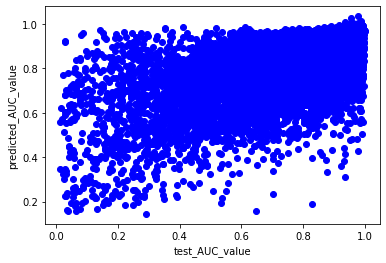

In [83]:
predicted_value = model.predict({'cell_input': test_cell_emb, 'drug_input': test_padel_features})
plt.scatter(test_y,predicted_value,c='blue')
plt.xlabel('test_AUC_value')
plt.ylabel('predicted_AUC_value')

In [84]:
a = pd.DataFrame(predicted_value)
b = pd.DataFrame(test_y)
c = pd.concat([a,b], axis=1)
c.columns=["Predicted","Test"]

In [85]:
rse = ((b[0]-a[0])**2).sum()
mse = rse / len(b)
print("Final rmse value is =",np.sqrt(mse))

Final rmse value is = 0.12807085961980627


In [86]:
mae = (np.abs(b[0]-a[0])).sum()
mae / len(b)

0.07730036887955459

In [87]:
mse

0.016402145083756123

In [88]:
from sklearn.metrics import r2_score
r2_value = r2_score(b, a) 
print(r2_value)

0.5123012358465762


In [89]:
full_test = pd.read_csv('/data/yingfei/cancer_data/test_data.csv')

full_test = full_test[['ARXSPAN_ID', 'DRUG_NAME']]
eval_data = test_data[['ARXSPAN_ID', 'DRUG_NAME', 'auc']].copy()
eval_data['pred_auc'] = predicted_value
eval_data

,ARXSPAN_ID,DRUG_NAME,auc,pred_auc
0,ACH-000802,JW-7-24-1,0.528562,0.700807
1,ACH-000802,KIN001-260,0.930958,0.926843
2,ACH-000802,NSC-87877,0.759249,0.863386
3,ACH-000802,PLX-4720,0.936510,0.956219
4,ACH-000802,ERK5-IN-1,0.823453,0.860413
...,...,...,...,...
22873,ACH-000438,KIN001-266,0.975578,0.754735
22874,ACH-000438,LUMINESPIB,0.980529,0.982019
22875,ACH-000438,NUTLIN-3A,0.960501,0.947060
22876,ACH-000438,SGC0946,0.970524,0.983547


In [90]:
full_test['comb'] = full_test.ARXSPAN_ID + full_test.DRUG_NAME
eval_data['comb'] = eval_data.ARXSPAN_ID + eval_data.DRUG_NAME
eval_data = pd.merge(full_test, eval_data, on = ['ARXSPAN_ID', 'DRUG_NAME'], how = 'left')

In [91]:
eval_data_arr = pd.DataFrame(eval_data.ARXSPAN_ID.unique(), columns = ['ARXSPAN_ID'])
eval_data_arr['true_auc_arr'] = [[] for _ in range(len(eval_data_arr))]
eval_data_arr['pred_auc_arr'] = [[] for _ in range(len(eval_data_arr))]
eval_data_arr

,ARXSPAN_ID,true_auc_arr,pred_auc_arr
0,ACH-000802,[],[]
1,ACH-001496,[],[]
2,ACH-000267,[],[]
3,ACH-000508,[],[]
4,ACH-001106,[],[]
...,...,...,...
64,ACH-000953,[],[]
65,ACH-000561,[],[]
66,ACH-000819,[],[]
67,ACH-000873,[],[]


In [92]:
for i in range(len(eval_data)):
    cl_id = eval_data.loc[i, 'ARXSPAN_ID']
    auc = eval_data.loc[i, 'auc']
    pred_auc =  eval_data.loc[i, 'pred_auc']
    if np.isnan(auc):
        #eval_data_arr.loc[eval_data_arr.ARXSPAN_ID == cl_id, 'true_auc_arr'].values[0].append(1)
        #eval_data_arr.loc[eval_data_arr.ARXSPAN_ID == cl_id, 'pred_auc_arr'].values[0].append(1)
        continue
    eval_data_arr.loc[eval_data_arr.ARXSPAN_ID == cl_id, 'true_auc_arr'].values[0].append(auc)
    eval_data_arr.loc[eval_data_arr.ARXSPAN_ID == cl_id, 'pred_auc_arr'].values[0].append(pred_auc)

In [93]:
pred_values = eval_data_arr.pred_auc_arr.apply(lambda x: np.array(x)).to_numpy()
true_values = eval_data_arr.true_auc_arr.apply(lambda x: np.array(x)).to_numpy()

In [94]:
### NDCG
from sklearn.metrics import ndcg_score
#ndcg_all = ndcg_score([p for p in pred_values],[t for t in true_values])
#ndcg_10 = ndcg_score([p for p in pred_values],[t for t in true_values], k = 10)
ndcg_all_values = []
ndcg_10_values = []
for i in range(len(pred_values)):
    pred_value = eval_data_arr['pred_auc_arr'].apply(lambda x:list(map(lambda y:1-y, x)))[i]
    true_value = eval_data_arr['true_auc_arr'].apply(lambda x:list(map(lambda y:1-y, x)))[i]
    ndcg_all_values.append(ndcg_score([pred_value],[true_value]))
    ndcg_10_values.append(ndcg_score([pred_value],[true_value], k = 10))
    
ndcg_all = np.mean(ndcg_all_values)
ndcg_10 = np.mean(ndcg_10_values)

print(ndcg_all)
print(ndcg_10)

0.932643113464056
0.7790959138686008


In [95]:
### Recall
results = []
for top_k in [1, 2, 5, 10]:
    dict_test_cell_line_idx_perf = {}
    for cur_cell_line_idx in range(len(pred_values)):
        # step 1
        # per the ground truth
        gt_aucs = true_values[cur_cell_line_idx]
        # find the top k drugs's idx
        topk_drug_idx_gt = np.argsort(gt_aucs)[:top_k]
        # step 2
        # per the predicted scores
        pred_scores = pred_values[cur_cell_line_idx]
        assert gt_aucs.shape == pred_scores.shape
        # find the top k drugs'idx (note: here its by pred scores)
        topk_drug_idx_pred = np.argsort(pred_scores)[:top_k]
        # step 3
        # recall@k
        cur_recall_at_k = len(
            set(topk_drug_idx_pred).intersection(set(topk_drug_idx_gt))
        ) / len(set(topk_drug_idx_gt))
        dict_test_cell_line_idx_perf[cur_cell_line_idx] = cur_recall_at_k

    avg_recall_at_k = np.mean(list(dict_test_cell_line_idx_perf.values()))
    results.append((f"Recall@{top_k}", round(avg_recall_at_k, 4)))
print(results)

[('Recall@1', 0.3768), ('Recall@2', 0.3913), ('Recall@5', 0.4116), ('Recall@10', 0.4493)]


In [96]:
### AUC
results = []
for top_k in [1, 2, 5, 10]:
    dict_test_cell_line_topk_auc_sum_gt = {}
    dict_test_cell_line_topk_auc_sum_pred = {}
    for cur_cell_line_idx in range(len(pred_values)):
        # step 1
        # per the predicted scores
        pred_scores = pred_values[cur_cell_line_idx]
        # find the top k drugs'idx (note: here its by pred scores)
        topk_drug_idx_pred = np.argsort(pred_scores)[:top_k]
        # step 2
        # per the ground truth
        gt_aucs = true_values[cur_cell_line_idx]
        # find the top k predicted drugs' (per ground truth) aucs
        topk_drug_idx_gt = np.argsort(gt_aucs)[:top_k]
        dict_test_cell_line_topk_auc_sum_gt[cur_cell_line_idx] = np.mean(
            gt_aucs[topk_drug_idx_gt]
        )
        dict_test_cell_line_topk_auc_sum_pred[cur_cell_line_idx] = np.mean(
            gt_aucs[topk_drug_idx_pred]
        )

    avg_auc_topk_gt = np.mean(
        list(dict_test_cell_line_topk_auc_sum_gt.values())
    )
    avg_auc_topk_pred = np.mean(
        list(dict_test_cell_line_topk_auc_sum_pred.values())
    )

    results.append(
        (
            f"Auc@{top_k}",
            f"{round(avg_auc_topk_pred, 4)} (GT: {round(avg_auc_topk_gt, 4)})",
        )
    )

print(results)

[('Auc@1', '0.2373 (GT: 0.1198)'), ('Auc@2', '0.3048 (GT: 0.157)'), ('Auc@5', '0.3751 (GT: 0.222)'), ('Auc@10', '0.4295 (GT: 0.2893)')]


In [97]:
from scipy.stats import pearsonr, spearmanr
print(pearsonr(c.Predicted, c.Test)[0], spearmanr(c.Predicted, c.Test)[0])

0.7325483720209628 0.7198399558385051
